In [4]:
from numpy import genfromtxt
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
import matplotlib.patches as mpatches


In [2]:

def fitFunc(tt, data, f2,  T):
    print(f2.shape)
    A1_g = np.std(data[:,0]) * 2.**0.5
    A2_g = np.std(data[:,1]) * 2.**0.5
    A3_g = np.std(data[:,2]) * 2.**0.5 
    
    w = 2*np.pi/T  
    
    p1, p2, p3 = 0, 0, 0
    
    c1_g =np.mean(data[:,0])
    c2_g =np.mean(data[:,1])
    c3_g =np.mean(data[:,2])
    guess = np.array([A1_g,A2_g,A3_g,p1,p2,p3, c1_g,c2_g,c3_g])
    
    def f(t, A1, A2, A3,p1,p2,p3, c1=0, c2=0, c3=0):  
        return np.sqrt(np.power(A1 * np.sin(w*t + p1) + c1,2)+ np.power(A2 * np.sin(w*t + p2) + c2,2)+np.power(A3 * np.sin(w*t + p3) + c3,2))
    
    def sinfunc(t, A, p, c=0):  
        return A * np.sin(w*t + p) + c
    
    def func(t, A1, A2, A3,p1,p2,p3, c1, c2, c3):
        out = np.array([sinfunc(t, A1, p1, c1),
                   sinfunc(t, A2, p2, c2),
                   sinfunc(t, A3, p3, c3),
                  f(t, A1, A2, A3,p1,p2,p3, c1, c2, c3)])
        return out.ravel()

    popt, pcov = scipy.optimize.curve_fit(func, tt, f2.T.ravel(), p0=guess)
    A1,A2,A3,p1,p2,p3, c1,c2,c3 = popt
    print(A3, p3,c3)
    fitfunc = lambda t: f(t, A1, A2, A3,p1,p2,p3)
    x = lambda k:  sinfunc(k, A1, p1)
    y = lambda t:  sinfunc(t, A2, p2)
    z = lambda t: sinfunc(t, A3, p3)
    return [fitfunc(tt),x(tt),y(tt),z(tt)]

In [3]:
ft = genfromtxt('ft_calibration_thesis.csv', delimiter=';')
data = ft[:,1:4]
#data[:,2] *= 0.972
f2 = np.sqrt(np.power(data[:,0],2) +np.power(data[:,1],2) +np.power(data[:,2],2))
f2 = f2[:,np.newaxis]
stack = np.hstack([data, f2])
tt = np.linspace(0, len(data)-1, len(data))

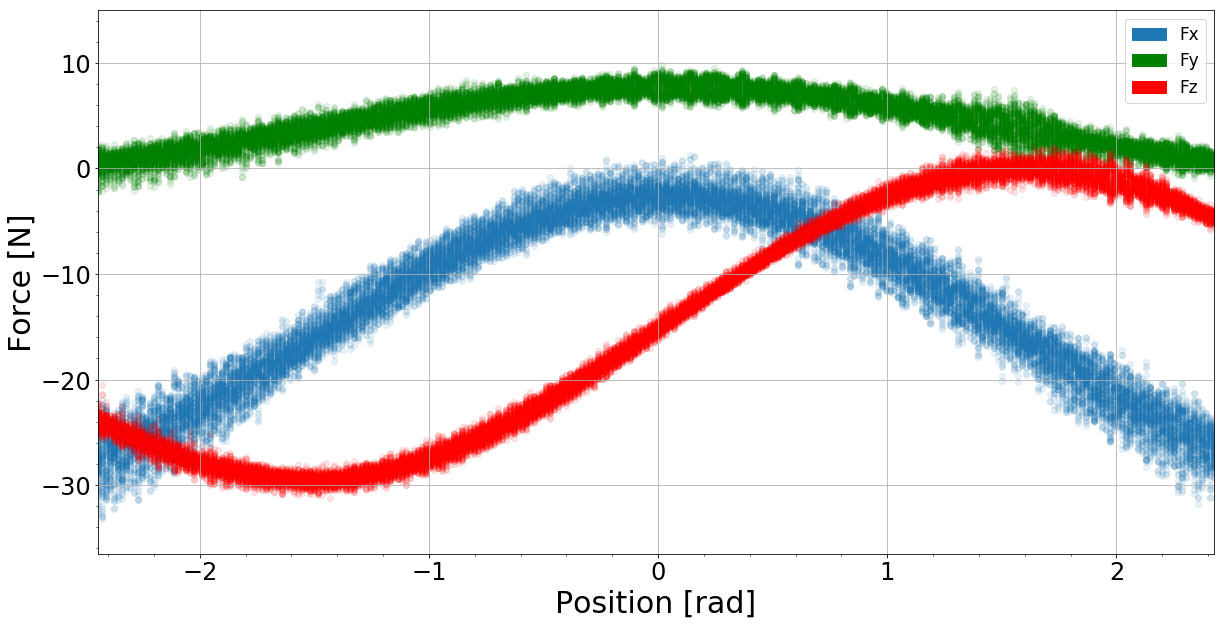

In [5]:
#Plot for readings of forces
blue_patch = mpatches.Patch(color='#1f77b4', label='Fx')
green_patch = mpatches.Patch(color='green', label='Fy')
red_patch = mpatches.Patch(color='red', label='Fz')

fig, ax1 = plt.subplots()
ax1.set_xlabel('Position [rad]', size=30)
ax1.set_ylabel('Force [N]', size=30)

t = ft[:,0]
plt.scatter(t,data[:,0],color='#1f77b4',alpha=0.1)
plt.scatter(t,data[:,1],color="green",alpha=0.1)
plt.scatter(t,data[:,2],color="red",alpha=0.1)
plt.plot()

ax1.set_xlim([min(t[:]),max(t)])
ax1.set_ylim([np.min(data)*1.1,15])
ax1.legend(handles=[blue_patch,green_patch,red_patch], prop={'size': 17})

ax1.tick_params(axis = 'both', which = 'major', labelsize = 24)
plt.minorticks_on()
plt.grid()
plt.savefig('/home/robotronics/Pictures/noisy_F_kalib.png', format='png', dpi=100)

(28000, 4)
(14.763905813718722, 0.7388522552434831, -14.733153693370095)


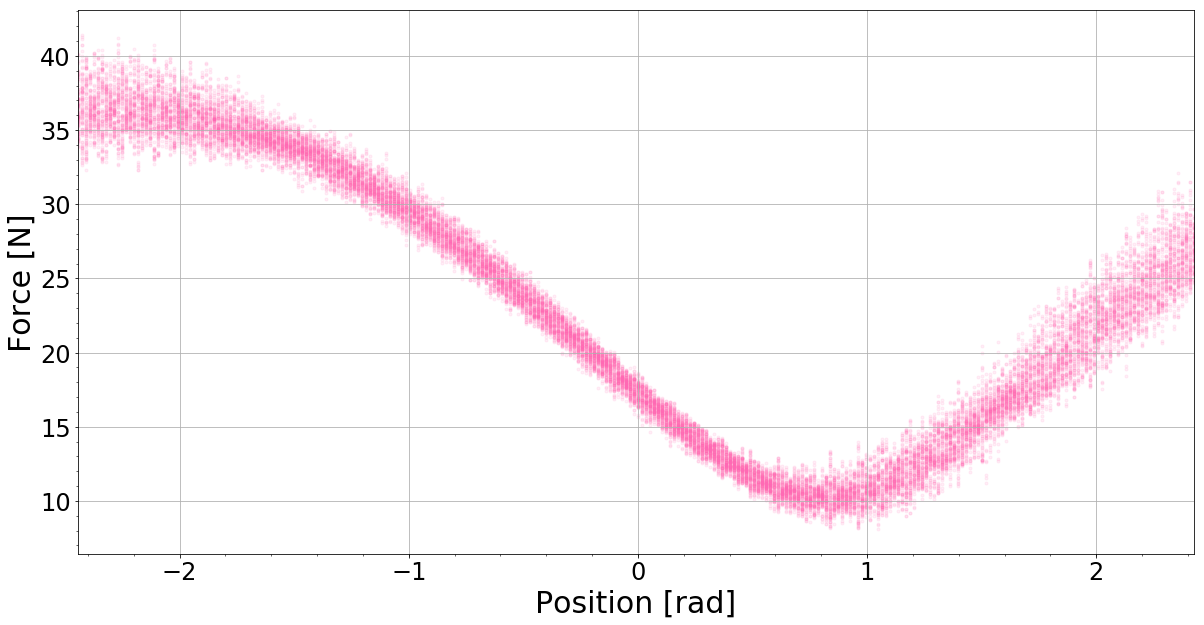

In [6]:
solution = fitFunc(tt, data, stack,  len(data)*9/7)
#plt.plot(solution[0],color="black")
#plt.plot(f2,alpha=0.3)
#plt.xlim([0,5000])

fig, ax1 = plt.subplots()
ax1.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax1.set_xlabel('Position [rad]', size=30)
ax1.set_ylabel('Force [N]', size=30)

t = ft[:,0]
plt.scatter(t,f2,color='hotpink',alpha=0.1,marker=".")
plt.plot()

ax1.set_xlim([min(t[:]),max(t)])
#ax1.set_ylim([np.min(f2)*1.1,np.max(f2)])

plt.minorticks_on()
plt.grid()
plt.savefig('/home/robotronics/Pictures/noisy_F_gravity.png', format='png', dpi=100)

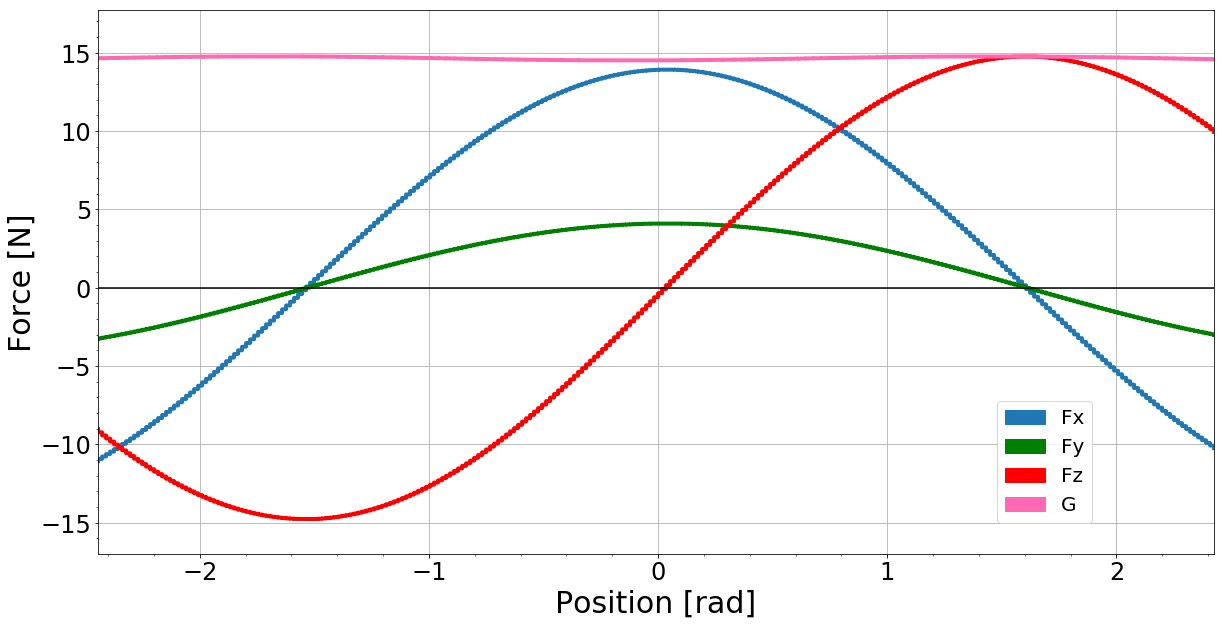

In [7]:
#Fitted functions
blue_patch = mpatches.Patch(color='#1f77b4', label='Fx')
green_patch = mpatches.Patch(color='green', label='Fy')
red_patch = mpatches.Patch(color='red', label='Fz')
pink_patch = mpatches.Patch(color='hotpink', label='G')

fig, ax1 = plt.subplots()
ax1.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax1.set_xlabel('Position [rad]', size=30)
ax1.set_ylabel('Force [N]', size=30)

t = ft[:,0]
plt.plot(t,solution[1],color='#1f77b4',linewidth=4)
plt.plot(t,solution[2],color="green",linewidth=4)
plt.plot(t,solution[3],color="red",linewidth=4)
plt.plot(t,solution[0],color='hotpink',linewidth=4)
plt.plot()

ax1.set_xlim([min(t[:]),max(t)])
ax1.set_ylim([np.min(solution[3])*1.15,np.max(solution[3])*1.2])
ax1.legend(handles=[blue_patch,green_patch,red_patch,pink_patch], prop={'size': 20}, bbox_to_anchor=(0.9,0.3))
plt.axhline(0,color="black")

plt.minorticks_on()
plt.grid()
plt.savefig('/home/robotronics/Pictures/clean_F_calib.png', format='png', dpi=100)

In [10]:
from scipy.optimize import minimize
def scaling(alfa):  
        return np.std(np.sqrt(np.power(solution[1],2) +np.power(solution[2],2) +np.power(alfa*solution[3],2)))
res = minimize(scaling, 1, method='L-BFGS-B', tol=1e-10)
print(res)

      fun: 0.02973723256377517
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.38777878e-09])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 5
   status: 0
  success: True
        x: array([0.9833219])


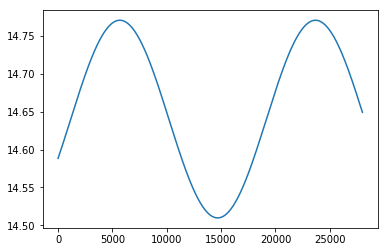

In [11]:
plt.plot(np.sqrt(np.power(solution[1],2) +np.power(solution[2],2) +np.power(solution[3],2)))

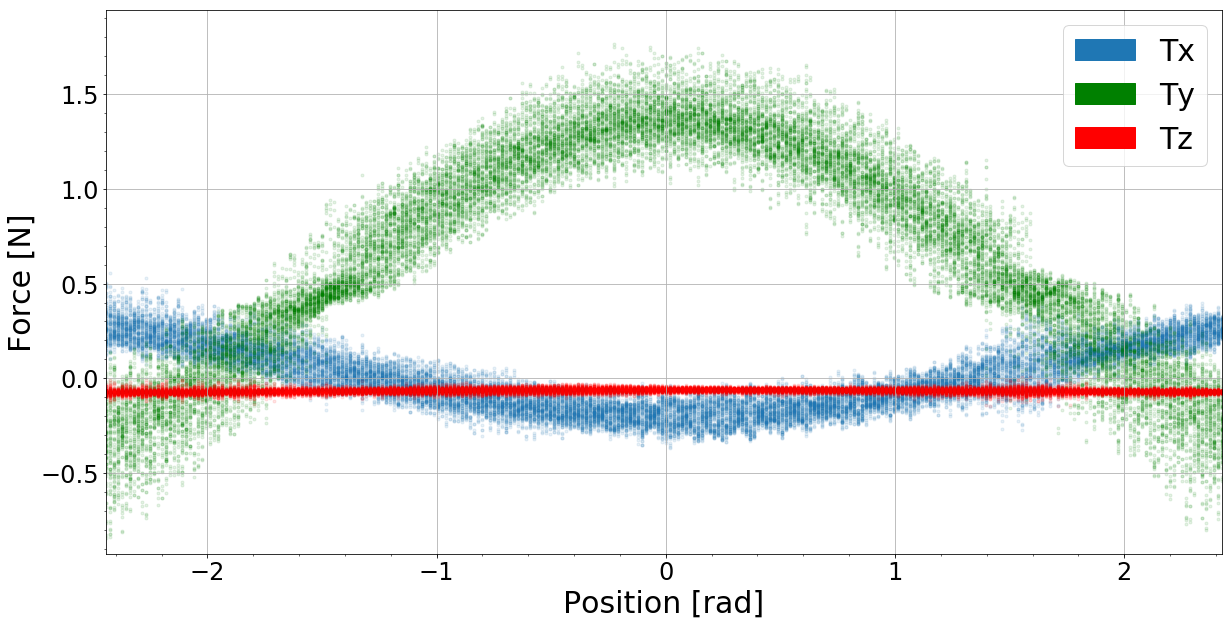

In [22]:
#Plot for readings of forces
data = ft[:,4:]

blue_patch = mpatches.Patch(color='#1f77b4', label='Tx')
green_patch = mpatches.Patch(color='green', label='Ty')
red_patch = mpatches.Patch(color='red', label='Tz')

fig, ax1 = plt.subplots()
ax1.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax1.set_xlabel('Position [rad]', size=30)
ax1.set_ylabel('Force [N]', size=30)

t = ft[:,0]
plt.scatter(t,data[:,0],color='#1f77b4',alpha=0.1,marker=".")
plt.scatter(t,data[:,1],color="green",alpha=0.1,marker=".")
plt.scatter(t,data[:,2],color="red",alpha=0.1,marker=".")
plt.plot()

ax1.set_xlim([min(t[:]),max(t)])
ax1.set_ylim([np.min(data)*1.1,np.max(data)*1.1])
ax1.legend(handles=[blue_patch,green_patch,red_patch], prop={'size': 30})

plt.minorticks_on()
plt.grid()
plt.savefig('/home/robotronics/Pictures/noisy_T_kalib.png', format='png', dpi=100)

In [34]:
def fitSin(tt, data, T):
    guess_amp = np.std(data) * 2.**0.5
    guess_offset = np.mean(data)
    guess_phase = 0
    guess = np.array([guess_amp,guess_phase , guess_offset])
    w = 2*np.pi/T
    def sinfunc(t, A, p, c):  
        return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, data, p0=guess,maxfev = 2000)
    A,  p, c = popt
    print(A,p,c)
    x = np.linspace(min(t),max(t),10000)
    fitfunc = lambda t: A * np.sin(w*t + p) 
    return fitfunc(tt)

(-0.2660247021719631, -0.821728438109405, 0.06929769581209645)
(28000,)
(0.9503429447284861, -0.8272442365988397, 0.42434683449538063)
(28000,)
(0.006672230922944928, -0.784086500351371, -0.066069030468665)
(28000,)


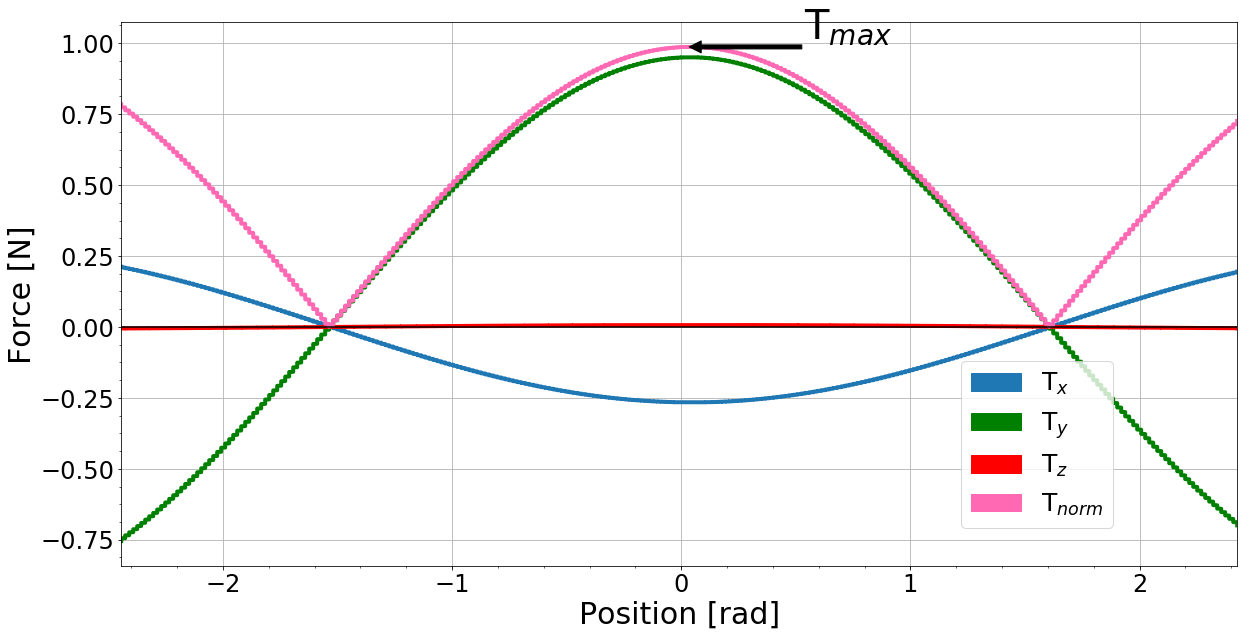

In [39]:
x_ = fitSin(tt, data[:,0], len(data)*9/7)
y_ = fitSin(tt, data[:,1], len(data)*9/7)
z_ = fitSin(tt, data[:,2], len(data)*9/7)
f2 = np.sqrt(np.power(x_,2) + np.power(y_,2) + np.power(z_,2)) 
#Fitted functions
blue_patch = mpatches.Patch(color='#1f77b4', label='T$_x$')
green_patch = mpatches.Patch(color='green', label='T$_y$')
red_patch = mpatches.Patch(color='red', label='T$_z$')
pink_patch = mpatches.Patch(color='hotpink', label='T$_{norm}$')

fig, ax1 = plt.subplots()
ax1.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax1.set_xlabel('Position [rad]', size=30)
ax1.set_ylabel('Force [N]', size=30)

x = np.linspace(min(t),max(t),10000)
plt.plot(t,x_,color='#1f77b4',linewidth=4)
plt.plot(t,y_,color="green",linewidth=4)
plt.plot(t,z_,color="red",linewidth=4)
plt.plot(t,f2,color='hotpink',linewidth=4)
plt.plot()

ax1.annotate('T$_{max}$', xy=(t[np.argmax(f2)], max(f2)), xytext=(t[np.argmax(f2)]+0.5, max(f2)),
            arrowprops=dict(facecolor='black'), fontsize = 40,verticalalignment='bottom'
            )

ax1.set_xlim([min(t[:]),max(t)])
#ax1.set_ylim([np.min(solution[3])*1.15,np.max(solution[3])*1.2])
ax1.legend(handles=[blue_patch,green_patch,red_patch,pink_patch], prop={'size': 25}, bbox_to_anchor=(0.9,0.4))
plt.axhline(0,color="black")

plt.minorticks_on()
plt.grid()
plt.savefig('/home/robotronics/Pictures/clean_T_calib.png', format='png', dpi=300)

In [56]:
t

array([ 2.42601,  2.42601,  2.42601, ..., -2.44346, -2.44346, -2.44346])